# GAN Application in Video Generation Example
A General Adversarial Network is trained to generate short 64 frame videos (gifs). In this example, the network is trained on a single video (64 frames) to illustrate its functionality. Thus, the network is overfit. The next step is to train the network on 2-3 minute videos and produce gifs based on input images (i.e. predicting future frames).

In [53]:
# %load '/Users/jesusnavarro/Desktop/gan_video/core/main.py'

# import dependencies
from keras_preprocessing.image import save_img
from torch import optim
from torch.utils.data import DataLoader
import torch.autograd
from torchvision.transforms import transforms
from torchvision.transforms import ToPILImage
import logging
from core.model import *
from core.UAVDataset import *
from examples.Logger import Logger
import sys
import imageio
from skimage import img_as_ubyte
from array2gif import write_gif



def make_gif(images, filename):
    ''' Helper method to create gif from images
    
    @param: images - tensor image of size (height, width, channels)
    @param: filename - str path to save gif
    '''
    x = images.permute(1,2,3,0)
    x = x.numpy()
    x = img_as_ubyte(x)
    frames = []
    for i in range(32):
        frames += [x[i]]
    imageio.mimsave(filename, frames, duration=0.1)

def denorm(x):
    ''' Helper method to denormalize the images
    
    @param x: tensor image (height, width, channels)
    '''
    out = (x + 1.0) / 2.0
    tf = nn.Tanh()
    return tf(out)


def setup_logger(logger_name):
    # format string
    LOG_FORMAT = "%(levelname)s - %(asctime)s - %(messages)s"
    logger = logging.getLogger(logger_name)

    # create formatter
    formatter = logging.Formatter(fmt=LOG_FORMAT)

    # create handler, streamhandler, and format
    file_handler = logging.FileHandler('training_log.txt', mode='w')
    file_handler.setFormatter(file_handler)
    screen_handler = logging.StreamHandler(stream=sys.stdout)
    screen_handler.setFormatter(formatter)
    logger.addHandler(file_handler)
    logger.addHandler(screen_handler)

    return logger


def save_image(img, filename):
    ''' Saves img to filename
    '''
    
    img = img.detach()
    pil_img = ToPILImage()
    img = pil_img(img)
    img.save(filename)




# Import and Visualize Sample Video

In [54]:
# Compose transforms to apply to the data
composed = transforms.Compose([Rescale(64), ToTensor()])

# Define location of data pickle files
# This example uses 32 boat9 image frames of UAV dataset 20 batches
working_dir = '/Users/jesusnavarro/Desktop/gan_video'
sub_dir = '/pickle_data/boat9_video_test_20_batches.pickle'

# Instantiate DataLoader object 
transformed_uav_dataset = UAVDataset(pickle_path=working_dir + sub_dir,
                                     transform=composed)

data_loader = DataLoader(transformed_uav_dataset,
                         batch_size=32,
                         shuffle=False)

# Save gif

In [47]:
nd = video_list[0][0].permute(1, 0, 2, 3, 4).numpy()[0]
print(nd)
write_gif(np.array(nd), 'sample_gif.gif', fps=32)


[[[[-0.21568626 -0.20784312 -0.19999999 ...  0.24705887  0.24705887
     0.24705887]
   [-0.17647058 -0.18431371 -0.1607843  ...  0.254902    0.27058828
     0.26274514]
   [-0.16862744 -0.15294117 -0.15294117 ...  0.27058828  0.27843142
     0.27058828]
   ...
   [-0.04313725 -0.4352941  -0.26274508 ...  0.13725495  0.02745104
     0.28627455]
   [-0.14509803 -0.6627451  -0.32549018 ...  0.4431373  -0.56078434
    -0.1372549 ]
   [-0.73333335 -0.6627451  -0.54509807 ... -0.00392157  0.15294123
     0.37254906]]

  [[-0.08235294 -0.0745098  -0.06666666 ...  0.34901965  0.34901965
     0.35686278]
   [-0.05098039 -0.05882353 -0.03529412 ...  0.34901965  0.36470592
     0.37254906]
   [-0.04313725 -0.02745098 -0.02745098 ...  0.36470592  0.37254906
     0.3803922 ]
   ...
   [ 0.15294123 -0.26274508 -0.09803921 ...  0.20784318  0.07450986
     0.36470592]
   [-0.01960784 -0.4352941  -0.0745098  ...  0.5137255  -0.41176468
    -0.04313725]
   [-0.4980392  -0.38823527 -0.29411763 ...  0.09

ValueError: The dataset has a value outside the range [0,255]
At position 0 in the list of arrays.

# Construct Generator and Discriminator Network

In [55]:
# Define parameters
d_loss, g_loss, d_real_output, d_fake_output = 0, 0, 0, 0
l1_lambda = 10
num_epochs = 120
batch_size = 32


# Instantiate generator and discriminator
generator = VideoGen().float()
discriminator = VideoDiscriminator().float()

# Directory to save generator videos
DIR_TO_SAVE = "./gen_videos/"
if not os.path.exists(DIR_TO_SAVE):
    os.makedirs(DIR_TO_SAVE)
sample_input = None
sample_input_set = False

# Define optimizer for the discriminator and generator

#d_optimizer = optim.RMSprop(discriminator.parameters(), lr=5e-5)
#g_optimizer = optim.RMSprop(generator.parameters(), lr=5e-5)

# Adam optimizer
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.555, 0.5))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.555, 0.5))

# Train GAN

In [ ]:
logger = Logger(model_name='VGAN', data_name='boat9') # Used only to display updates 
for epoch in range(num_epochs):
    save = True # boolean to save gif
    for (iter_num, batch) in enumerate(data_loader, 1):
        
        real_video = batch['video'][0]
        filenames = batch['video'][1]
        real_video = torch.squeeze(real_video, dim=1).unsqueeze(0)
        
        # reset gradients
        generator.zero_grad()
        discriminator.zero_grad()
        
        N = real_video.size(0)

        real_labels = torch.LongTensor(np.ones(N, dtype=int))
        fake_labels = torch.LongTensor(np.zeros(N,  dtype=int))


        # Train discriminator
        d_real_output_sig, d_real_output = discriminator(real_video.permute(0, 2, 1, 3, 4).float())
        d_real_output_sig, d_real_output = d_real_output_sig.squeeze(), d_real_output.squeeze()

        # Generate a fake video, detach parameters
        latent_z = torch.randn(N, 100, 1, 1, 1)
        fake_video = generator(latent_z).detach()
        
        # Discriminator outputs sigmoid output and raw output (WGAN/Vanilla GAN)
        d_fake_output_sig, d_fake_output = discriminator(fake_video)

        # Compute real and fake loss
        if N == 1:
            d_fake_output = d_fake_output.squeeze().unsqueeze(0)
            d_real_output = d_real_output.squeeze().unsqueeze(0)
        else:
            d_fake_output = d_fake_output.squeeze()
            d_real_output = d_real_output.squeeze()

        d_loss = -(torch.mean(d_real_output) - torch.mean(d_fake_output))

        # Update Gradient
        d_loss.backward()
        d_optimizer.step()

        for p in discriminator.parameters():
            p.data.clamp_(-0.01, 0.01)

        if iter_num % 2 == 0:  # Train generator
            first_frame = real_video[0:1, 0:1, :, :, :].squeeze()
            latent_z = torch.randn(N, 100, 1, 1, 1)
            fake_videos = generator(latent_z)
            d_fake_outputs_sig, d_fake_outputs = discriminator(fake_videos)
            d_fake_outputs_sig, d_fake_outputs = d_fake_outputs_sig.squeeze(), d_fake_outputs.squeeze()
            gen_first_frame = fake_videos[0:1, :, 0:1, :, :].squeeze()
            reg_loss = torch.mean(torch.abs(real_video.float() - fake_videos.permute(0,2,1,3,4).float())) * l1_lambda
            g_loss = -torch.mean(d_fake_outputs) + reg_loss
            g_loss.backward()
            g_optimizer.step()

        if iter_num % 5 == 0:
            logger.display_status(
                epoch, num_epochs, iter_num, len(data_loader),
                d_loss, g_loss, d_real_output, d_fake_output
            )

            if (epoch + 1) % 10 == 0 and save:
                # Generate video to save
                sample_input = torch.randn(N, 100, 1, 1, 1)
                gen_out = generator(sample_input)
                
                # Save video from generator
                make_gif(denorm(gen_out.data.cpu()[0]),
                         DIR_TO_SAVE + 'fake_gifs_sample_it%s_epoch%s.gif' % (iter_num, epoch))
                save = False

# Visualize Training Improvement

The gifs are displayed below for epochs 10, 40, 60, and 120. Recall that the GAN performs well since there is overfitting. Only a single video is being used to train the GAN for demonstration purposes.

In [80]:
gifs = ["./gen_videos/fake_gifs_sample_it5_epoch9.gif",
       "./gen_videos/fake_gifs_sample_it5_epoch39.gif",
       "./gen_videos/fake_gifs_sample_it5_epoch59.gif",
       "./gen_videos/fake_gifs_sample_it5_epoch119.gif"]
from IPython.display import Image


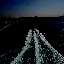

In [99]:
# Real video (compressed)
# Images were normalized
make_gif(real_video.squeeze().permute(1, 0, 2, 3), DIR_TO_SAVE + 'real_video.gif')
Image(filename= DIR_TO_SAVE + 'real_video.gif', width=250, height=200)

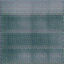

In [83]:
# Epoch 10
Image(filename=gifs[0] , width=250, height=200)

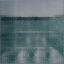

In [84]:
# Epoch 40
Image(filename=gifs[1] , width=250, height=200)

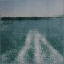

In [86]:
# Epoch 60
Image(filename=gifs[2] , width=250, height=200)

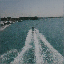

In [87]:
# Epoch 120
Image(filename=gifs[3] , width=250, height=200)
